In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr
from sklearn.decomposition import randomized_svd
from scipy.signal import find_peaks
import datetime
import time
#import winsound#sound alarm when code finishes, only in windows
import pandas as pd
import seaborn as sns

from SemiNE.utils import *
from SemiNE.train import *
from chirpMB import *

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    # reproducible
#
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
#device=torch.device('cpu')
EPOCH = 50
LR=0.0001 # 1e-4
L2=0.0

In [3]:
# for plot figures
plt.rcParams.update({'figure.max_open_warning': 0})
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'
# axis spine
#use it like: adjust_spines(ax, ['left', 'bottom'])
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  # outward by 2 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [4]:
training_inputs = np.load('../data/fig3_training_inputs.npy')
training_set = np.load('../data/fig3_training_set.npy')
test_inputs = np.load('../data/fig3_test_inputs.npy')
test_set = np.load('../data/fig3_test_set.npy')
movie_bgr_h5 = np.load('../data/fig3_movie_bgr_h5.npy')

In [5]:
#split original training data into two parts, training loader: 2200, validation loader: 200
#make the dataset suitable for pytorch and semi-supervised learning
train_loader=[]
for ii in range(20):
    #neural data
    temp0=training_inputs[ii*110:ii*110+110] -0.5 #center the stimulus
    temp1=training_set[ii*110:ii*110+110]#100*200(neurons)
    #natural image data
    temp2=movie_bgr_h5[ii*900:ii*900+900] 
    temp=(temp0,temp1,temp2)
    #temp=(temp0,temp1)
    train_loader.append(temp)
#
temp0=training_inputs[2200:] -0.5 #center the stimulus
temp1=training_set[2200:]#200*200(neurons)
temp2=movie_bgr_h5[18000:19600]
#val_loader=(temp0,temp1)
val_loader=(temp0,temp1,temp2)
#
temp0=np.copy(test_inputs) -0.5 #center the stimulus
temp1=np.copy(test_set)#50*200(neurons)
temp2=movie_bgr_h5[19600:]
#test_loader=(temp0,temp1)
test_loader=(temp0,temp1,temp2)
#
print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0][0]:')
print (train_loader[0][0].shape)
print ('shape of train_loader[0][1]:')
print (train_loader[0][1].shape)
print ('shape of train_loader[0][2]:')
print (train_loader[0][2].shape)
#
print ('shape of val_loader[0]:')
print (val_loader[0].shape)
print ('shape of val_loader[1]:')
print (val_loader[1].shape)
print ('shape of val_loader[2]:')
print (val_loader[2].shape)
#
print ('shape of test_loader[0]:')
print (test_loader[0].shape)
print ('shape of test_loader[1]:')
print (test_loader[1].shape)
print ('shape of test_loader[2]:')
print (test_loader[2].shape)

length of train_loader:
20
shape of train_loader[0][0]:
(110, 2, 8, 28, 28)
shape of train_loader[0][1]:
(110, 96)
shape of train_loader[0][2]:
(900, 2, 28, 28)
shape of val_loader[0]:
(200, 2, 8, 28, 28)
shape of val_loader[1]:
(200, 96)
shape of val_loader[2]:
(1600, 2, 28, 28)
shape of test_loader[0]:
(50, 2, 8, 28, 28)
shape of test_loader[1]:
(50, 96)
shape of test_loader[2]:
(400, 2, 28, 28)


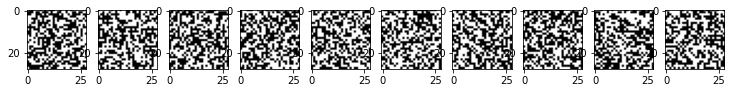

In [6]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(train_loader[0][0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

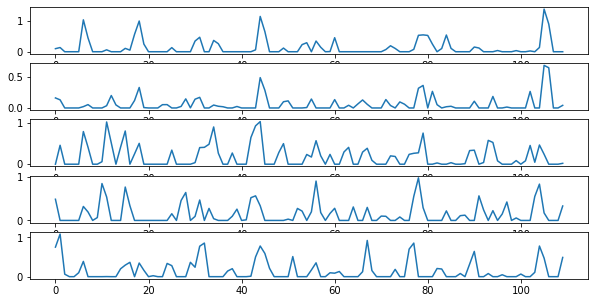

In [7]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(train_loader[0][1][:,ii])

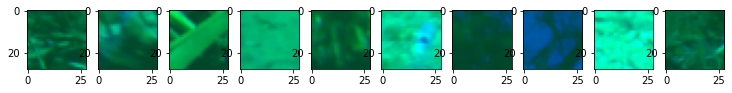

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    #axes[ii].imshow(train_loader[0][ii,0,...],cmap='gray',vmin=0,vmax=255)
    temp=np.zeros((28,28,3),np.uint8)
    temp[...,1:]=np.transpose(train_loader[0][2][ii],(1,2,0))[...,::-1]
    axes[ii].imshow(img_real2view(temp))
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

In [11]:
#preprocess: centered data
sky_bg_mean_f   = np.mean(movie_bgr_h5[:18000],axis=(0,2,3))/255
print (sky_bg_mean_f)

[0.19641674 0.20930869]


In [12]:
#function: visualize conv0 weights
def Vis_conv3d_0(conv3d_0,temptitle):
    #UV channel
    weight_min=np.min(conv3d_0)
    weight_max=np.max(conv3d_0)
    if weight_max>(weight_min*(-1.0)):
        weight_min=weight_max*(-1.0)
    if weight_max<(weight_min*(-1.0)):
        weight_max=weight_min*(-1.0)
    #(outd,ind,height,weight)=conv3d_0.shape
    fig, axes = plt.subplots(nrows=int(len(conv3d_0)/8), ncols=8,figsize=(10, int(len(conv3d_0)/8)))
    for ii in range(int(len(conv3d_0)/8)):
        for jj in range(8):
            axes[ii,jj].imshow(conv3d_0[ii*8+jj,0,...],vmin=weight_min,vmax=weight_max,cmap='bwr')
            axes[ii,jj].set_xticks([]),axes[ii,jj].set_yticks([])
            if ii==0 and jj==0:
                axes[ii,jj].set_title(str(temptitle))

##  <font color='red'>Model architecture</font> 

In [13]:
class ModelSemiSL3d1(nn.Module):
    def __init__(self):
        super(ModelSemiSL3d1, self).__init__()
        #supervised
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=96 #number of neurons
        #spatial kernel, self.kernel_size=9 #odd number
        self.conv1_ss=nn.Parameter(torch.zeros(self.numoffea,2,1,9,9))
        std=1. / np.sqrt(2*1*9*9)
        self.conv1_ss.data.uniform_(-std*0.1, std*0.1)
        self.conv1_ss_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_ss_bias.data.uniform_(-std, std)
        #temporal kernel
        self.conv1_st=nn.Conv3d(self.numoffea,self.numoffea,kernel_size=(8,1,1),stride=1)
        #fc layer
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #autoencoder
        #self.ae_conv1_b=nn.Parameter(torch.zeros(self.numoffea)).requires_grad_(requires_grad=True)
        #stdv           = 1. / np.sqrt(2*9*9)
        #self.ae_conv1_b.data.uniform_(-stdv, stdv)
        #
        self.ae_dconv1 =nn.ConvTranspose3d(self.numoffea,2,kernel_size=(1,9,9),stride=1,padding=(0,4,4))
        self.ae_fc1    =nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_dfc1   = nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_encoder = nn.Sequential(
            #self.conv1, #16,28*28
            nn.ReLU(),
            Flatten3D(),
            self.ae_fc1,
            nn.ReLU(),
            GaussianNoise(sigma=1)
        )
        self.ae_decoder = nn.Sequential(
            self.ae_dfc1,
            nn.ReLU(),
            Unflatten3D(-1,self.numoffea,1,28,28),
            self.ae_dconv1, #2,28*28
            nn.Tanh())
    #
    def forward(self, x, z):
        #supervised
        encoded = F.conv3d(x, self.conv1_ss, bias=self.conv1_ss_bias,stride=1,padding=(0,0,0))
        encoded = self.conv1_st(encoded)
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        #autoencoder
        #z          = z.unsqueeze(2) 
        ae_encoded = F.conv3d(z, self.conv1_ss, bias=self.conv1_ss_bias,stride=1,padding=(0,4,4))
        ae_encoded = self.ae_encoder(ae_encoded)
        ae_decoded = self.ae_decoder(ae_encoded)
        #ae_decoded = ae_decoded.squeeze(2) 
        return encoded, ae_encoded, ae_decoded
#for visualization of RFs
class ModelSemiSL3d1_copy(nn.Module):
    def __init__(self,conv1_st_weight,conv1_st_bias,conv1_ss,conv1_ss_bias,fc1_weight,fc1_bias):
        super(ModelSemiSL3d1_copy, self).__init__()
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=96 #number of neurons
        #spatial kernel, self.kernel_size=9 #odd number
        self.conv1_ss=nn.Parameter(torch.zeros(self.numoffea,2,1,9,9))
        std=1. / np.sqrt(2*1*9*9)
        self.conv1_ss.data.uniform_(-std*0.1, std*0.1)
        self.conv1_ss_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_ss_bias.data.uniform_(-std, std)
        #temporal kernel
        self.conv1_st=nn.Conv3d(self.numoffea,self.numoffea,kernel_size=(8,1,1),stride=1)
        #fc layer
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #
        self.conv1_st.weight.data.copy_(conv1_st_weight.clone().detach())
        self.conv1_st.bias.data.copy_(conv1_st_bias.clone().detach())
        self.conv1_ss.data.copy_(conv1_ss.clone().detach())
        self.conv1_ss_bias.data.copy_(conv1_ss_bias.clone().detach())
        self.fc1.weight.data.copy_(fc1_weight.clone().detach())
        self.fc1.bias.data.copy_(fc1_bias.clone().detach())
    #
    def forward(self, x):
        encoded = F.conv3d(x, self.conv1_ss, bias=self.conv1_ss_bias,stride=1,padding=(0,0,0))
        encoded = self.conv1_st(encoded)
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        return encoded

##  <font color='red'>Train the model with different weights</font> 

In [18]:
#Semi-supervised learning, ModelSemiSL2d1()
EPOCH=100 
LR = 1e-4
alpha1s = [1e1]
alpha2s = [1e1]
beta1s  =[1/256] #[0.0,1/4,1,4,16]
alpha3s =[1e3]
beta2s  =[1/16]
seeds   =[1]
lossweights=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0] # [0.01]
#modeltrainloss=[]
modelvalloss=[]
for ii in range(len(seeds)):
    for jj in range(len(lossweights)):
        seedname=str(ii+1)
        modelname=str(jj+1)
        torch.manual_seed(seeds[ii])    # reproducible
        torch.cuda.manual_seed(seeds[ii])
        tempmodel = ModelSemiSL3d1()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        model_train(tempmodel,train_loader,optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                    alpha1=alpha1s[0],alpha2=alpha2s[0],\
                    beta1=beta1s[0],alpha3=alpha3s[0],beta2=beta2s[0],lossweight=lossweights[jj],earlystop=True,verbose=True) 
        #modeltrainloss.append(temp)
        #
        torch.save(tempmodel.state_dict(),\
                   './out/20200429_v4_ModelSemiSL3d1_dorsal_upandlow_seed_'+seedname+'_weight_'+modelname+'.pth')
        
        temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
        modelvalloss.append(temp)
        del tempmodel
        torch.cuda.empty_cache()

2020-08-18 18:13:32.193056
Model:  ModelSemiSL3d1 |Epoch:  0 | train loss: 1.0044
Model:  ModelSemiSL3d1 |Epoch:  1 | train loss: 0.6427
Model:  ModelSemiSL3d1 |Epoch:  2 | train loss: 0.4564
Model:  ModelSemiSL3d1 |Epoch:  3 | train loss: 0.4123
Model:  ModelSemiSL3d1 |Epoch:  4 | train loss: 0.4071
Model:  ModelSemiSL3d1 |Epoch:  5 | train loss: 0.4048
Model:  ModelSemiSL3d1 |Epoch:  6 | train loss: 0.4035
Model:  ModelSemiSL3d1 |Epoch:  7 | train loss: 0.4031
Model:  ModelSemiSL3d1 |Epoch:  8 | train loss: 0.4029
Model:  ModelSemiSL3d1 |Epoch:  9 | train loss: 0.4028
Model:  ModelSemiSL3d1 |Epoch:  10 | train loss: 0.4027
Model:  ModelSemiSL3d1 |Epoch:  11 | train loss: 0.4027
Model:  ModelSemiSL3d1 |Epoch:  12 | train loss: 0.4026
Model:  ModelSemiSL3d1 |Epoch:  13 | train loss: 0.4026
Model:  ModelSemiSL3d1 |Epoch:  14 | train loss: 0.4025
Model:  ModelSemiSL3d1 |Epoch:  15 | train loss: 0.4025
Model:  ModelSemiSL3d1 |Epoch:  16 | train loss: 0.4024
Model:  ModelSemiSL3d1 |Epoch: 

In [19]:
print (modelvalloss)

[0.2711441389121134, 0.27115076211320854, 0.2759365596634949, 0.27546514089914526, 0.2787433040123107, 0.28897024636572255, 0.29511646168334954, 0.30088069619112173, 0.312172040991459, 0.2338740528755648, 0]


## Val CC against weights

In [14]:
valloss_hne = np.load('../data/20200429_ModelSemiSL3d1_dorsal_val_loss_v4.npy')
valloss_upandlow = np.copy(valloss_hne[0])
valloss_phaScr   = np.copy(valloss_hne[1])
valloss_noise    = np.copy(valloss_hne[2])

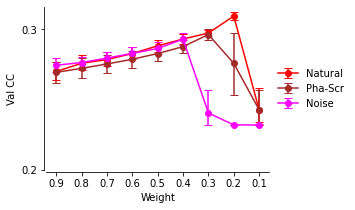

In [17]:
lossweights=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1] 
val_losses = [valloss_upandlow, valloss_phaScr, valloss_noise]
means = [np.mean(ii,axis=0) for ii in val_losses]
means = np.array(means)
lowqs=np.zeros_like(means) #lower_quartile
higqs=np.zeros_like(means) #upper_quartile
for ii in range(len(means)):
    for jj in range(means.shape[1]):
        temp=val_losses[ii][:,jj]
        low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
        lowqs[ii,jj]  = means[ii,jj]-low_perc
        higqs[ii,jj]  =-means[ii,jj]+high_perc 
#
templabels=[]
for ii in range(len(lossweights)):
    templabels.append(str(lossweights[ii]))
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(4,3))
ax.errorbar(np.arange(len(lossweights)), means[0,1:10], yerr=(lowqs[0,1:10],higqs[0,1:10]),\
            marker='o', color='red',linestyle='-', label='Natural',alpha=1, capsize=4)
ax.errorbar(np.arange(len(lossweights)), means[1,1:10], yerr=(lowqs[1,1:10],higqs[1,1:10]),\
            marker='o', color='brown',linestyle='-', label='Pha-Scr',alpha=1, capsize=4)
ax.errorbar(np.arange(len(lossweights)), means[2,1:10], yerr=(lowqs[2,1:10],higqs[2,1:10]),\
            marker='o', color='magenta',linestyle='-', label='Noise',alpha=1, capsize=4)

ax.set_xticks(np.arange(len(lossweights)).tolist())
ax.set_yticks([0.2,0.3])
ax.set_xticklabels(templabels)
ax.set_xlabel('Weight')
ax.set_ylabel('Val CC')
ax.legend(loc='best')
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result/20200429_ModelSemiSL3d1_dorsal_upandlow_allSeeds_allWeights_allInput_ValCCs.svg', \
#            bbox_extra_artists=(lgd,), bbox_inches='tight')

In [18]:
valloss_dct=np.load('../data/20200429_ModelSE3d1_Neu150qi_ST_Exp_dct_Ploss_val_loss_v4.npy')
print (valloss_dct.shape)
print (valloss_dct[:,2])
valloss_pca=np.load('../data/20200429_ModelSE3d1_Neu150qi_ST_Exp_pca_Ploss_val_loss_v4.npy')
print (valloss_pca.shape)
print (valloss_pca[:,2])

(10, 7)
[0.29723271 0.29808441 0.30312281 0.30758992 0.30672229 0.3008997
 0.31671003 0.3012567  0.3094869  0.31357334]
(10, 7)
[0.29633392 0.28423016 0.28226157 0.29178325 0.28785579 0.2836933
 0.27601791 0.28998788 0.29838508 0.28754601]


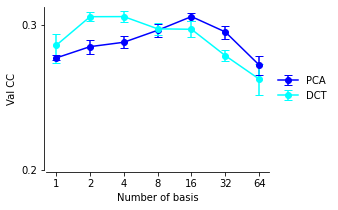

In [20]:
val_losses = [valloss_pca, valloss_dct]
means = [np.mean(ii,axis=0) for ii in val_losses]
means = np.array(means)
lowqs=np.zeros_like(means) #lower_quartile
higqs=np.zeros_like(means) #upper_quartile
for ii in range(len(means)):
    for jj in range(means.shape[1]):
        temp=val_losses[ii][:,jj]
        low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
        lowqs[ii,jj]  = means[ii,jj]-low_perc
        higqs[ii,jj]  =-means[ii,jj]+high_perc 
#
numofbasis=[1,2,4,8,16,32,64]
templabels=[]
for ii in range(len(numofbasis)):
    templabels.append(str(numofbasis[ii]))
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(4,3))
ax.errorbar(np.arange(len(means[0,:])),means[0,:], yerr=(lowqs[0,:],higqs[0,:]),\
            marker='o', color='blue',linestyle='-', label='PCA',alpha=1, capsize=4)
ax.errorbar(np.arange(len(means[0,:])),means[1,:], yerr=(lowqs[1,:],higqs[1,:]),\
            marker='o', color='cyan',linestyle='-', label='DCT',alpha=1, capsize=4)
#
ax.set_xticks(np.arange(len(means[0,:])).tolist())
ax.set_yticks([0.2,0.3])
#ax.set_ylim([0.22,0.33])
ax.set_xticklabels(templabels)
ax.set_xlabel('Number of basis')
ax.set_ylabel('Val CC')
ax.legend(loc='best')
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))

## Test CC for different models

In [21]:
testlosses=[]
#SNE
testloss_sne     =np.load('../data/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_test_loss_v4.npy')
print (testloss_sne.shape)
testlosses.append(testloss_sne)
#HNE-Natural
testloss_hne_natural=np.load('../data/20200429_ModelSemiSL3d1_dorsal_upandlow_test_loss_v4.npy')
print (testloss_hne_natural.shape)
testlosses.append(testloss_hne_natural)
#HNE-Pha-Scr
testloss_hne_pha_scr=np.load('../data/20200429_ModelSemiSL3d1_dorsal_upandlow_phasescramble_test_loss_v4.npy')
print (testloss_hne_pha_scr.shape)
testlosses.append(testloss_hne_pha_scr)
#HNE-Noise
testloss_hne_noise=np.load('../data/20200429_ModelSemiSL3d1_dorsal_noise_test_loss_v4.npy')
print (testloss_hne_noise.shape)
testlosses.append(testloss_hne_noise)
#SNE-PCA
testloss_sne_pca =np.load('../data/20200429_ModelSE3d1_Neu150qi_ST_Exp_pca_Ploss_test_loss_v4.npy')
print (testloss_sne_pca.shape)
testlosses.append(testloss_sne_pca)
#SNE-DCT
testloss_sne_dct =np.load('../data/20200429_ModelSE3d1_Neu150qi_ST_Exp_dct_Ploss_test_loss_v4.npy')
print (testloss_sne_dct.shape)
testlosses.append(testloss_sne_dct)
#
testlosses=np.array(testlosses)
print (testlosses.shape)

(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(6, 10)


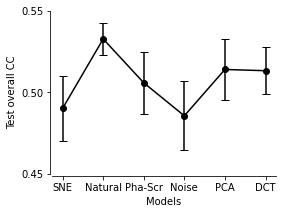

In [22]:
testlosses_mean  =np.mean(testlosses, axis=1)
testlosses_std   =np.std( testlosses, axis=1,ddof=1)
#
templabels=['SNE','Natural','Pha-Scr','Noise','PCA','DCT']
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(4,3))
ax.errorbar(np.arange(len(testlosses_mean)),testlosses_mean,yerr=testlosses_std,\
            marker='o', color='k',linestyle='-', alpha=1, capsize=4)
#
ax.set_xticks(np.arange(len(testlosses_mean)).tolist())
ax.set_yticks([0.45,0.50,0.55])
ax.set_xticklabels(templabels)
ax.set_xlabel('Models')
ax.set_ylabel('Test overall CC')
adjust_spines(ax, ['left', 'bottom'])

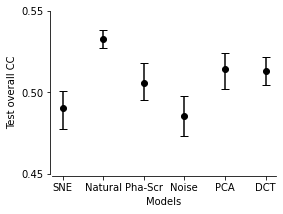

In [23]:
#plot
temps=[ii for ii in testlosses]
means = [np.mean(ii) for ii in temps]
lowqs=np.zeros(len(temps)) #lower_quartile
higqs=np.zeros(len(temps)) #upper_quartile
for ii in range(len(temps)):
    temp=temps[ii]
    low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
    lowqs[ii]  = means[ii]-low_perc
    higqs[ii]  =-means[ii]+high_perc 
#
templabels=['SNE','Natural','Pha-Scr','Noise','PCA','DCT']
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(4,3))
ax.errorbar(np.arange(len(means)),means,yerr=(lowqs,higqs),\
            marker='o', color='k',linestyle='None', alpha=1, capsize=4)
#
ax.set_xticks(np.arange(len(testlosses_mean)).tolist())
ax.set_yticks([0.45,0.50,0.55])
ax.set_xticklabels(templabels)
ax.set_xlabel('Models')
ax.set_ylabel('Test overall CC')
adjust_spines(ax, ['left', 'bottom'])
#ax.legend(loc='best')
#handles, labels = ax.get_legend_handles_labels()
#lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result/20200429_all2DModels_TestCCs.svg', \
#            bbox_extra_artists=(lgd,), bbox_inches='tight')
#fig.savefig('out_result/20200429_all2DModels_TestCCs.svg')

In [24]:
#permutation test
#https://stackoverflow.com/questions/24795535/pythons-implementation-of-permutation-test-with-permutation-number-as-input
#permutation test using monte-carlo method
def perm_test(xs, ys, nmc, randomseed):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc
def perm_test_group(list_of_array,nmc=10000,randomseed=66):
    perm_res=[]
    for ii in np.arange(len(list_of_array)):
        for jj in np.arange(ii+1,len(list_of_array)):
            temp=perm_test(list_of_array[ii], list_of_array[jj], nmc, (ii*jj+jj+randomseed)*nmc)
            perm_res.append(temp)
    return perm_res
#
temp=[ii for ii in testlosses]
print (perm_test_group(temp,nmc=10000,randomseed=66))

[0.0, 0.0858, 0.6332, 0.0134, 0.0073, 0.0016, 0.0, 0.009, 0.0017, 0.0375, 0.339, 0.3307, 0.0068, 0.0034, 0.9229]


## Plot R squared

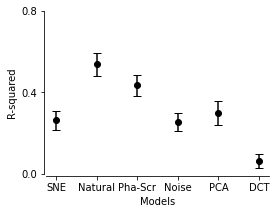

In [25]:
#conv0, fit to 2d Gaussian, measure goodness, for 6 tyeps of models and 10 random seeds
#only use green channel, bootstrap
cha = 1 # UV, G = 0, 1
r2_ss=np.zeros((6,160)) # 160 = 10(seeds) x 16(kernels) x 1(colour)

#SNE
r2_ss[0] =np.load('../data/20200429_ModelSE3d1_Neu150_ST_Exp_dorsal_conv0_fit_r2_v4.npy').reshape(-1,2)[:,cha]
#HNE-natural
r2_ss[1] =np.load('../data/20200429_ModelSemiSL3d1_dorsal_upandlow_conv0_fit_r2_v4.npy').reshape(-1,2)[:,cha]
#HNE-pha-scr
r2_ss[2] =np.load('../data/20200429_ModelSemiSL3d1_dorsal_upandlow_phasescramble_conv0_fit_r2_v4.npy').reshape(-1,2)[:,cha]
#HNE-noise
r2_ss[3] =np.load('../data/20200429_v4_ModelSemiSL3d1_dorsal_noise_conv0_fit_r2_v4.npy').reshape(-1,2)[:,cha]
#SNE-PCA
r2_ss[4] =np.load('../data/20200429_ModelSE3d1_Neu150_ST_Exp_pca_dorsal_conv0_fit_r2_v4.npy').reshape(-1,2)[:,cha]
#SNE-DCT
r2_ss[5] =np.load('../data/20200429_ModelSE3d1_Neu150_ST_Exp_dct_dorsal_conv0_fit_r2_v4.npy').reshape(-1,2)[:,cha]

#
temps=[ii for ii in r2_ss]
means = [np.mean(ii) for ii in temps]
lowqs=np.zeros(len(temps)) #lower_quartile
higqs=np.zeros(len(temps)) #upper_quartile
for ii in range(len(temps)):
    temp=temps[ii]
    low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
    lowqs[ii]  = means[ii]-low_perc
    higqs[ii]  =-means[ii]+high_perc 
#
templabels=['SNE','Natural','Pha-Scr','Noise','PCA','DCT']
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(4,3))
ax.errorbar(np.arange(len(means)),means,yerr=(lowqs,higqs),\
            marker='o', color='k',linestyle='None', alpha=1, capsize=4)
#
ax.set_yticks([0,0.4,0.8])
ax.set_xticks(np.arange(len(means)).tolist())
ax.set_xticklabels(templabels)
ax.set_xlabel('Models')
ax.set_ylabel('R-squared')
adjust_spines(ax, ['left', 'bottom'])

In [28]:
r2_hne = np.load('../data/rebuttal_20200429_ModelSemiSL3d1_dorsal_r2_hne_v4.npy')
r2_upandlow = np.copy(r2_hne[0])
r2_phaScr   = np.copy(r2_hne[1])
r2_noise    = np.copy(r2_hne[2])
print (r2_upandlow.shape)

(11, 160)


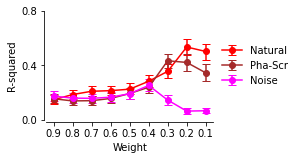

In [29]:
#plot fitting goodness for conv0, for all weights and seeds
#only green, bootstrap
val_losses = [r2_upandlow[1:-1], r2_phaScr[1:-1], r2_noise[1:-1]] #exclude 1, 0
means = [np.mean(ii,axis=1) for ii in val_losses]
means = np.array(means)
lowqs=np.zeros_like(means) #lower_quartile
higqs=np.zeros_like(means) #upper_quartile
for ii in range(len(means)):
    for jj in range(means.shape[1]):
        temp=val_losses[ii][jj,:]
        low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
        lowqs[ii,jj]  = means[ii,jj]-low_perc
        higqs[ii,jj]  =-means[ii,jj]+high_perc 
#
lossweights=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1] #exclude 1, 0
templabels=[]
for ii in range(len(lossweights)):
    templabels.append(str(lossweights[ii]))
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,2))
ax.errorbar(np.arange(len(lossweights)), means[0,:], yerr=(lowqs[0,:],higqs[0,:]),\
            marker='o', color='red',linestyle='-', label='Natural',alpha=1, capsize=4)
ax.errorbar(np.arange(len(lossweights)), means[1,:], yerr=(lowqs[1,:],higqs[1,:]),\
            marker='o', color='brown',linestyle='-', label='Pha-Scr',alpha=1, capsize=4)
ax.errorbar(np.arange(len(lossweights)), means[2,:], yerr=(lowqs[2,:],higqs[2,:]),\
            marker='o', color='magenta',linestyle='-', label='Noise',alpha=1, capsize=4)

ax.set_xticks(np.arange(len(lossweights)).tolist())
ax.set_yticks([0,0.4,0.8])
#ax.set_ylim([0.22,0.33])
ax.set_xticklabels(templabels)
ax.set_xlabel('Weight')
ax.set_ylabel('R-squared')
ax.legend(loc='best')
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result/rebuttal_20200429_ModelSemiSL3d1_dorsal_upandlow_allSeeds_allWeights_allInput_r2s.svg', \
#            bbox_extra_artists=(lgd,), bbox_inches='tight')

## Plot: data size

(8, 10)
(8, 10)


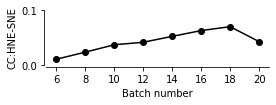

In [41]:
#test CC
#SNE
testloss_sne = []
temp = np.load('../data/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_test_loss_bnum_v4.npy')
for ii in range(len(temp)):
    testloss_sne.append(temp[ii])
testloss_sne.append(np.load('../data/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_test_loss_v4.npy'))
testloss_sne = np.array(testloss_sne)
print (testloss_sne.shape)

#HNE-Natural
testloss_hne_natural = []
temp = np.load('../data/20200429_ModelSemiSL3d1_dorsal_upandlow_test_loss_bnum_v4.npy')
for ii in range(len(temp)):
    testloss_hne_natural.append(temp[ii])
testloss_hne_natural.append(np.load('../data/20200429_ModelSemiSL3d1_dorsal_upandlow_test_loss_v4.npy'))
testloss_hne_natural = np.array(testloss_hne_natural)
print (testloss_hne_natural.shape)

#plot
testloss_sne_mean  =np.mean(testloss_sne, axis=1)
testloss_sne_std   =np.std( testloss_sne, axis=1,ddof=1)
testloss_hne_natural_mean  =np.mean(testloss_hne_natural, axis=1)
testloss_hne_natural_std   =np.std( testloss_hne_natural, axis=1,ddof=1)
#
templabels=['6','8','10','12','14','16','18','20']
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(4,1))
ax.plot(np.arange(len(testloss_sne_mean)),testloss_hne_natural_mean - testloss_sne_mean,\
            marker='o', color='k',linestyle='-', alpha=1)
ax.set_xticks(np.arange(len(testloss_sne_mean)).tolist())
ax.set_yticks([0, 0.1])
ax.set_xticklabels(templabels)
ax.set_xlabel('Batch number')
ax.set_ylabel('CC:HNE-SNE')
adjust_spines(ax, ['left', 'bottom'])

(8, 10)
(8, 10)


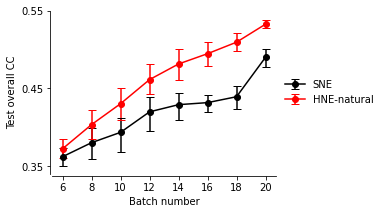

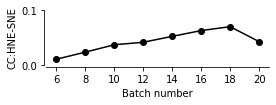

In [42]:
#test CC, bootstrap
#SNE
testloss_sne = []
temp = np.load('../data/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_test_loss_bnum_v4.npy')
for ii in range(len(temp)):
    testloss_sne.append(temp[ii])
testloss_sne.append(np.load('../data/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_test_loss_v4.npy'))
testloss_sne = np.array(testloss_sne)
print (testloss_sne.shape)

#HNE-Natural
testloss_hne_natural = []
temp = np.load('../data/20200429_ModelSemiSL3d1_dorsal_upandlow_test_loss_bnum_v4.npy')
for ii in range(len(temp)):
    testloss_hne_natural.append(temp[ii])
testloss_hne_natural.append(np.load('../data/20200429_ModelSemiSL3d1_dorsal_upandlow_test_loss_v4.npy'))
testloss_hne_natural = np.array(testloss_hne_natural)
print (testloss_hne_natural.shape)

#plot
val_losses = [testloss_sne, testloss_hne_natural]
means = [np.mean(ii,axis=1) for ii in val_losses]
means = np.array(means)
lowqs=np.zeros_like(means) #lower_quartile
higqs=np.zeros_like(means) #upper_quartile
for ii in range(len(means)):
    for jj in range(means.shape[1]):
        temp=val_losses[ii][jj,:]
        low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
        lowqs[ii,jj]  = means[ii,jj]-low_perc
        higqs[ii,jj]  =-means[ii,jj]+high_perc 
#
templabels=['6','8','10','12','14','16','18','20']
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(4,3))
ax.errorbar(np.arange(len(means[0,:])),means[0,:], yerr=(lowqs[0,:],higqs[0,:]),\
            marker='o', color='k',linestyle='-', alpha=1, capsize=4, label='SNE')
ax.errorbar(np.arange(len(means[0,:])),means[1,:], yerr=(lowqs[1,:],higqs[1,:]),\
            marker='o', color='r',linestyle='-', alpha=1, capsize=4, label='HNE-natural')
ax.set_xticks(np.arange(len(means[0,:])).tolist())
ax.set_yticks([0.35,0.45,0.55])
ax.set_xticklabels(templabels)
ax.set_xlabel('Batch number')
ax.set_ylabel('Test overall CC')
adjust_spines(ax, ['left', 'bottom'])
ax.legend(loc='best')
handles, labels = ax.get_legend_handles_labels() 
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))

fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(4,1))
ax.plot(np.arange(len(means[0,:])),testloss_hne_natural_mean - testloss_sne_mean,\
            marker='o', color='k',linestyle='-', alpha=1)
ax.set_xticks(np.arange(len(means[0,:])).tolist())
ax.set_yticks([0, 0.1])
ax.set_xticklabels(templabels)
ax.set_xlabel('Batch number')
ax.set_ylabel('CC:HNE-SNE')
adjust_spines(ax, ['left', 'bottom'])

(8, 320)
(8, 320)


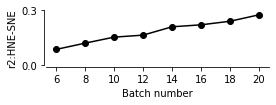

In [43]:
#R-squared
#SNE
r2_sne = []
temp = np.load('../data/20200429_ModelSE3d1_Neu150_ST_Exp_dorsal_conv0_fit_r2_bnum_v4.npy')
for ii in range(len(temp)):
    r2_sne.append(temp[ii])
r2_sne.append(np.load('../data/20200429_ModelSE3d1_Neu150_ST_Exp_dorsal_conv0_fit_r2_v4.npy'))
r2_sne = np.array(r2_sne)
print (r2_sne.shape)

#HNE-Natural
r2_hne_natural = []
temp = np.load('../data/20200429_ModelSemiSL3d1_dorsal_upandlow_conv0_fit_r2_bnum_v4.npy')
for ii in range(len(temp)):
    r2_hne_natural.append(temp[ii])
r2_hne_natural.append(np.load('../data/20200429_ModelSemiSL3d1_dorsal_upandlow_conv0_fit_r2_v4.npy'))
r2_hne_natural = np.array(r2_hne_natural)
print (r2_hne_natural.shape)

#plot
r2_sne_mean  =np.mean(r2_sne, axis=1)
r2_sne_std   =np.std( r2_sne, axis=1,ddof=1)
r2_hne_natural_mean  =np.mean(r2_hne_natural, axis=1)
r2_hne_natural_std   =np.std( r2_hne_natural, axis=1,ddof=1)
#
templabels=['6','8','10','12','14','16','18','20']
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(4,1))
ax.plot(np.arange(len(r2_sne_mean)),r2_hne_natural_mean - r2_sne_mean,\
            marker='o', color='k',linestyle='-', alpha=1)
ax.set_xticks(np.arange(len(testloss_sne_mean)).tolist())
ax.set_yticks([0, 0.3])
ax.set_xticklabels(templabels)
ax.set_xlabel('Batch number')
ax.set_ylabel('r2:HNE-SNE')
adjust_spines(ax, ['left', 'bottom'])

(8, 160)
(8, 160)


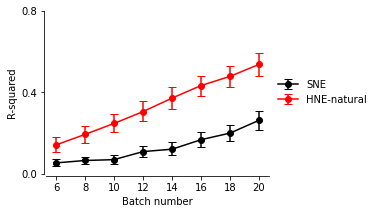

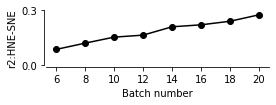

In [44]:
#R-squared, only green channel, bootstrap
cha = 1 # UV, G = 0, 1
#SNE
r2_sne = []
temp = np.load('../data/20200429_ModelSE3d1_Neu150_ST_Exp_dorsal_conv0_fit_r2_bnum_v4.npy')
for ii in range(len(temp)):
    r2_sne.append(temp[ii])
r2_sne.append(np.load('../data/20200429_ModelSE3d1_Neu150_ST_Exp_dorsal_conv0_fit_r2_v4.npy'))
r2_sne = np.array(r2_sne).reshape(8,-1,2)[:,:,cha]
print (r2_sne.shape)

#HNE-Natural
r2_hne_natural = []
temp = np.load('../data/20200429_ModelSemiSL3d1_dorsal_upandlow_conv0_fit_r2_bnum_v4.npy')
for ii in range(len(temp)):
    r2_hne_natural.append(temp[ii])
r2_hne_natural.append(np.load('../data/20200429_ModelSemiSL3d1_dorsal_upandlow_conv0_fit_r2_v4.npy'))
r2_hne_natural = np.array(r2_hne_natural).reshape(8,-1,2)[:,:,cha]
print (r2_hne_natural.shape)

#plot
val_losses = [r2_sne, r2_hne_natural]
means = [np.mean(ii,axis=1) for ii in val_losses]
means = np.array(means)
lowqs=np.zeros_like(means) #lower_quartile
higqs=np.zeros_like(means) #upper_quartile
for ii in range(len(means)):
    for jj in range(means.shape[1]):
        temp=val_losses[ii][jj,:]
        low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
        lowqs[ii,jj]  = means[ii,jj]-low_perc
        higqs[ii,jj]  =-means[ii,jj]+high_perc 
#
templabels=['6','8','10','12','14','16','18','20']
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(4,3))
ax.errorbar(np.arange(len(means[0,:])),means[0,:], yerr=(lowqs[0,:],higqs[0,:]),\
            marker='o', color='k',linestyle='-', alpha=1, capsize=4, label='SNE')
ax.errorbar(np.arange(len(means[0,:])),means[1,:], yerr=(lowqs[1,:],higqs[1,:]),\
            marker='o', color='r',linestyle='-', alpha=1, capsize=4, label='HNE-natural')
ax.set_xticks(np.arange(len(means[0,:])).tolist())
ax.set_yticks([0,0.4,0.8])
ax.set_xticklabels(templabels)
ax.set_xlabel('Batch number')
ax.set_ylabel('R-squared')
adjust_spines(ax, ['left', 'bottom'])
ax.legend(loc='best')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result/20200429_r2s_batchnumber.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')

fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(4,1))
ax.plot(np.arange(len(r2_sne_mean)),r2_hne_natural_mean - r2_sne_mean,\
            marker='o', color='k',linestyle='-', alpha=1)
ax.set_xticks(np.arange(len(testloss_sne_mean)).tolist())
ax.set_yticks([0, 0.3])
ax.set_xticklabels(templabels)
ax.set_xlabel('Batch number')
ax.set_ylabel('r2:HNE-SNE')
adjust_spines(ax, ['left', 'bottom'])